## Importação das bibliotecas

In [4]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

### Dataset: Leitura, normalização e visualização dos dados

In [5]:
# Load the dataset
url = "https://raw.githubusercontent.com/danysenosdados/RNA-e-Deep-Learning---CESAR-School-2025.01/main/Atividade%20Aula%203/student_exam_data.csv"
df = pd.read_csv(url)
df

,Study Hours,Previous Exam Score,Pass/Fail
0,4.370861,81.889703,0
1,9.556429,72.165782,1
2,7.587945,58.571657,0
3,6.387926,88.827701,1
4,2.404168,81.083870,0
...,...,...,...
495,4.180170,45.494924,0
496,6.252905,95.038815,1
497,1.699612,48.209118,0
498,9.769553,97.014241,1


#### Seleção de features e alvo

In [6]:
X = df[['Study Hours', 'Previous Exam Score']].values
Y = df['Pass/Fail'].values  # 0 = Falhou, 1 = Passou

#### Normalização Min-Max

In [7]:
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xs[Xs == 0] = 1  # Evita divisão por zero
Xc = Xc / Xs

#### Visualização dos dados

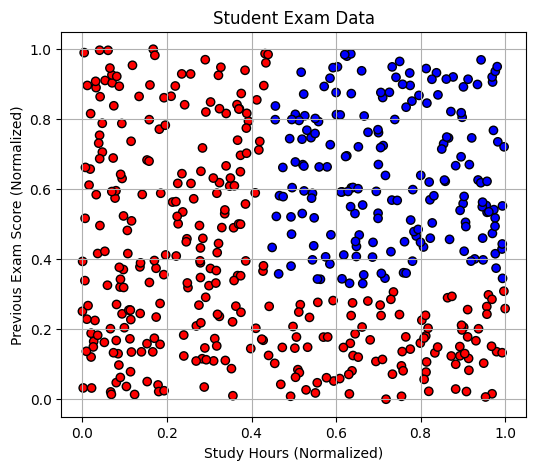

In [8]:
colors = np.array(['r', 'b'])  # r = falhou, b = passou
plt.figure(figsize=(6, 5))
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y], edgecolors='k')
plt.xlabel('Study Hours (Normalized)')
plt.ylabel('Previous Exam Score (Normalized)')
plt.title('Student Exam Data')
plt.grid(True)
plt.show()

### Preparação para PyTorch

In [9]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

#### Modelo de Regressão Logística

In [10]:
model = nn.Linear(2, 2)  # 2 entradas, 2 saídas

#### Função de predição

In [11]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)
    return predicts.data.numpy()

### Treinamento

In [12]:
lr = 0.15
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
nb_epoch = 10000
losses = []

for i in range(nb_epoch):
    output = model(Variable(X_tensor))
    loss = criterion(output, Variable(Y_tensor))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print(f'Final loss: {losses[-1]:.4f}')

Final loss: 0.2693


#### Salvamento dos pesos

In [13]:
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/student_exam_model.pt')

#### Carregamento dos pesos

In [14]:
model_loaded = nn.Linear(2, 2)
model_loaded.load_state_dict(torch.load('models/student_exam_model.pt'))

<All keys matched successfully>

### Avaliação

In [15]:
Y_pred = predict(model_loaded, X_tensor)
accuracy = (Y_pred == Y).mean()
print(f'Training Accuracy: {accuracy:.4f}')

conf_matrix = pd.crosstab(Y_pred, Y, rownames=['Predicted'], colnames=['Actual'])
conf_matrix

Training Accuracy: 0.8680


Actual,0,1
Predicted,,
0,284,34
1,32,150


#### Visualização dos resultados

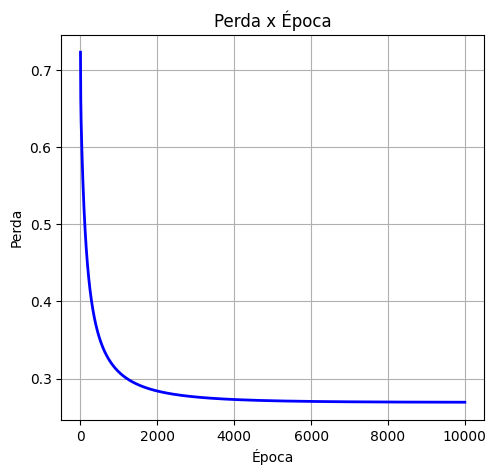

In [16]:
plt.figure(figsize=(12, 5))

# Gráfico da perda
plt.subplot(1, 2, 1)
plt.plot(np.arange(nb_epoch), losses, 'b', linewidth=2.0)
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Perda x Época')
plt.grid(True)

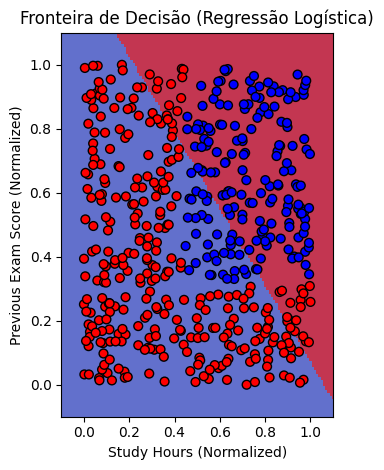

In [17]:
# Fronteira de decisão
x_min, x_max = Xc[:, 0].min() - 0.1, Xc[:, 0].max() + 0.1
y_min, y_max = Xc[:, 1].min() - 0.1, Xc[:, 1].max() + 0.1
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X_grid = np.c_[xx.ravel(), yy.ravel()]
Zc = predict(model_loaded, torch.FloatTensor(X_grid)).reshape(xx.shape)

plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, Zc, cmap=plt.cm.coolwarm, shading='auto', alpha=0.8)
plt.scatter(Xc[:, 0], Xc[:, 1], s=40, c=colors[Y], edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Study Hours (Normalized)')
plt.ylabel('Previous Exam Score (Normalized)')
plt.title('Fronteira de Decisão (Regressão Logística)')
plt.tight_layout()
plt.savefig('training_results.png')
plt.show()